In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack, csr_matrix
from textblob import TextBlob
import nltk
import re
import datetime
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from wordcloud import WordCloud, STOPWORDS 

%matplotlib inline

import warnings

warnings.simplefilter('ignore')

In [2]:
train = pd.read_csv('train_file.csv')
test = pd.read_csv('test_file.csv')
submission = pd.read_csv('sample_submission.csv')
test_id = test['IDLink']

In [3]:
train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084


In [4]:
test.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn
0,tFrqIR6Chj,Sliding Economy: FG fights back with N3trn TSA...,With the 2016 budget now passed by the Nationa...,BusinessDay,economy,2016-03-29 01:41:12,0,0,1
1,DVAaGErjlF,Microsoft shows how HoloLens can bring distant...,A recent Microsoft Research video shows how th...,Daily Mail,microsoft,2016-03-29 01:41:27,121,2,13
2,OT9UIZm5M2,"Microsoft’s Twitter Robot Praises Hitler, Trum...",* Microsoft teamed with Bing to create TayTwee...,EURweb,microsoft,2016-03-29 01:47:00,12,1,0
3,lflGp3q2Fj,Flood of Central Bank Moves Can't Get World Ec...,Central bankers have managed to steer the worl...,Bloomberg via Yahoo! Finance,economy,2016-03-29 02:00:00,0,0,3
4,zDYG0SoovZ,USD/JPY: bears lining up on mixed U.S. economy...,"However, this streak of seven-day gains might ...",FXStreet,economy,2016-03-29 02:01:07,3,0,0


In [6]:
train.describe()

,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
count,55932.000000,55932.000000,55932.000000,55932.000000,55932.000000
mean,132.050329,4.551616,14.300132,-0.006318,-0.029577
std,722.931314,21.137177,76.651420,0.137569,0.143038
min,-1.000000,-1.000000,-1.000000,-0.838525,-0.755355
25%,0.000000,0.000000,0.000000,-0.079057,-0.116927
50%,6.000000,0.000000,0.000000,0.000000,-0.027277
75%,37.000000,2.000000,4.000000,0.063969,0.057354
max,49211.000000,1267.000000,3716.000000,0.962354,0.964646


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55932 entries, 0 to 55931
Data columns (total 11 columns):
IDLink               55932 non-null object
Title                55932 non-null object
Headline             55932 non-null object
Source               55757 non-null object
Topic                55932 non-null object
PublishDate          55932 non-null object
Facebook             55932 non-null int64
GooglePlus           55932 non-null int64
LinkedIn             55932 non-null int64
SentimentTitle       55932 non-null float64
SentimentHeadline    55932 non-null float64
dtypes: float64(2), int64(3), object(6)
memory usage: 4.7+ MB


# Data Wrangling

Checking null values

In [5]:
train_df.isnull().sum()

IDLink                 0
Title                  0
Headline               0
Source               175
Topic                  0
PublishDate            0
Facebook               0
GooglePlus             0
LinkedIn               0
SentimentTitle         0
SentimentHeadline      0
dtype: int64

In [6]:
test_df.isnull().sum()

IDLink           0
Title            0
Headline         0
Source         101
Topic            0
PublishDate      0
Facebook         0
GooglePlus       0
LinkedIn         0
dtype: int64

In [8]:
train['Source'].value_counts()

Bloomberg                                    992
Reuters                                      763
ABC News                                     645
New York Times                               573
The Guardian                                 551
                                            ... 
TV Guide (blog)                                1
Olive Press                                    1
Enterprise Leader                              1
Pajhwok Afghan News (subscription) (blog)      1
The Jacksonville Daily News                    1
Name: Source, Length: 4753, dtype: int64

Treatment of NaN values

In [9]:
train['Source'] = train['Source'].fillna('Bloomberg')
test['Source'] = test['Source'].fillna('Bloomberg')

Data processing and cleaning

In [10]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

def clean(text):
  text_token = word_tokenize(text)
  filtered_text = ' '.join([w.lower() for w in text_token if w.lower() not in stop and len(w) > 2])
  filtered_text = filtered_text.replace(r"[^a-zA-Z]+", '')
  text_only = re.sub(r'\b\d+\b', '', filtered_text)
  clean_text = text_only.replace(',', '').replace('.', '').replace(':', '')
  return clean_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VISHAL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VISHAL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\VISHAL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [11]:
train['Text_Title'] = train['Title'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Title'] = test['Title'] + ' ' + test['Source'] + ' ' + test['Topic']

train['Text_Headline'] = train['Headline'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Headline'] = test['Headline'] + ' ' + test['Source'] + ' ' + test['Topic']

In [12]:
train['Text_Title'][4]

'Tourism, govt spending buoys Thai economy in January The Nation - Thailand&#39;s English news economy'

In [15]:
train['Text_Title'] = [clean(x) for x in train['Text_Title']]
test['Text_Title'] = [clean(x) for x in test['Text_Title']]

train['Text_Headline'] = [clean(x) for x in train['Text_Headline']]
test['Text_Headline'] = [clean(x) for x in test['Text_Headline']]

In [16]:
train['Text_Title'][4]

'tourism govt spending buoys thai economy january nation thailand english news economy'

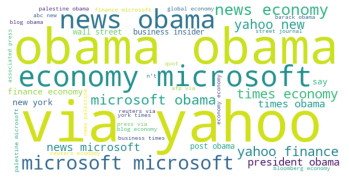

In [17]:
text = ""
for ind, row in train.iterrows():
    text += row["Text_Title"] + " "
text = text.strip()

wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=100, max_words=40).generate(text)
wordcloud.recolor(random_state=ind*312)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

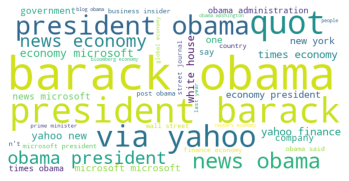

In [18]:
text = ""
for ind, row in train.iterrows():
    text += row["Text_Headline"] + " "
text = text.strip()

wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=100, max_words=40).generate(text)
wordcloud.recolor(random_state=ind*312)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Feature engineering and extraction

In [19]:
vectorizer = TfidfVectorizer(use_idf=True)

train_v_Title = vectorizer.fit_transform(train['Text_Title'])
test_v_Title = vectorizer.transform(test['Text_Title'])

vectorizer_ = TfidfVectorizer()

train_v_Headline = vectorizer_.fit_transform(train['Text_Headline'])
test_v_Headline = vectorizer_.transform(test['Text_Headline'])

Now, we will try to calculate the sentiment of our text corpus with their semantic meaning

In [20]:
train['polarity_t'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_t'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_t'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_t'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [21]:
train['polarity_h'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_h'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_h'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_h'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

Encoding the categorical variables

In [22]:
encoder = LabelEncoder()

train['Topic'] = encoder.fit_transform(train['Topic'])
test['Topic'] = encoder.transform(test['Topic'])

total = train['Source'].to_list() + test['Source'].to_list()
total = encoder.fit_transform(total)
train['Source'] = encoder.transform(train['Source'])
test['Source'] = encoder.transform(test['Source'])

Extracting days from date and time

In [23]:
train_weekday = []
test_weekday = []

for i in train['PublishDate']:
    train_weekday.append(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%A"))
    
for i in test['PublishDate']:
    test_weekday.append(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%A"))

train['weekday'] = train_weekday
test['weekday'] = test_weekday


# convert weekday to 0-6

train['weekday'] = train['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})
test['weekday'] = test['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})

Hour from date

In [24]:
train["hour"] = train["PublishDate"].apply(lambda x: x.split()[1].split(':')[0])
test["hour"] = test["PublishDate"].apply(lambda x: x.split()[1].split(':')[0])

# Exploratory Data Analysis (EDA)

Text(0, 0.5, 'SentimentTitle')

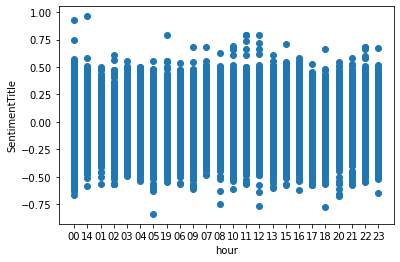

In [25]:
# hour distribution of SentimentTitle

plt.scatter(train['hour'], train['SentimentTitle'])
plt.xlabel('hour')
plt.ylabel('SentimentTitle')

Text(0, 0.5, 'SentimentHeadline')

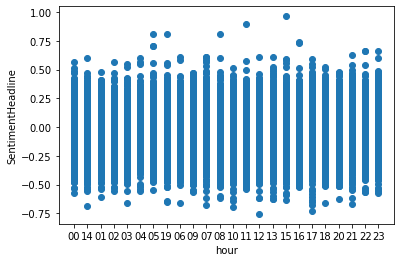

In [26]:
# hour distribution of SentimentHeadline

plt.scatter(train['hour'], train['SentimentHeadline'])
plt.xlabel('hour')
plt.ylabel('SentimentHeadline')

Text(0, 0.5, 'SentimentTitle')

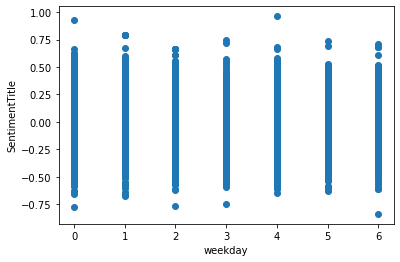

In [27]:
# weekday distribution of SentimentTitle

plt.scatter(train['weekday'], train['SentimentTitle'])
plt.xlabel('weekday')
plt.ylabel('SentimentTitle')

Text(0, 0.5, 'SentimentHeadline')

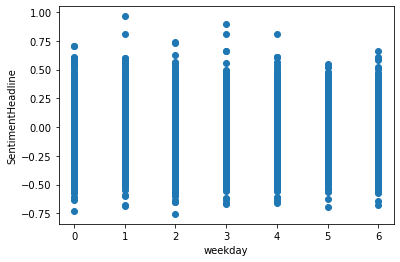

In [28]:
# weekday distribution of SentimentHeadline

plt.scatter(train['weekday'], train['SentimentHeadline'])
plt.xlabel('weekday')
plt.ylabel('SentimentHeadline')

In [29]:
# Number of words in the Title 
train["num_words_t"] = train["Text_Title"].apply(lambda x: len(str(x).split()))
test["num_words_t"] = test["Text_Title"].apply(lambda x: len(str(x).split()))

# Number of unique words in the Title 
train["num_unique_words_t"] = train["Text_Title"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_t"] = test["Text_Title"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the Title 
train["num_chars_t"] = train["Text_Title"].apply(lambda x: len(str(x)))
test["num_chars_t"] = test["Text_Title"].apply(lambda x: len(str(x)))

# Average length of the words in the Title 
train["mean_word_len_t"] = train["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_t"] = test["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [30]:
# Number of words in the Headline 
train["num_words_h"] = train["Text_Headline"].apply(lambda x: len(str(x).split()))
test["num_words_h"] = test["Text_Headline"].apply(lambda x: len(str(x).split()))

# Number of unique words in the Headline 
train["num_unique_words_h"] = train["Text_Headline"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_h"] = test["Text_Headline"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the Headline 
train["num_chars_h"] = train["Text_Headline"].apply(lambda x: len(str(x)))
test["num_chars_h"] = test["Text_Headline"].apply(lambda x: len(str(x)))

# Average length of the words in the Headline 
train["mean_word_len_h"] = train["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_h"] = test["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

Scaling using Column Standardization

In [31]:
scaler = StandardScaler()

cols = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_t', 'num_unique_words_t', 'num_chars_t', 'mean_word_len_t',
        'num_words_h', 'num_unique_words_h', 'num_chars_h', 'mean_word_len_h', 'hour', 'weekday']

for col in cols:
  train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
  test[col] = scaler.transform(test[col].values.reshape(-1, 1))

In [32]:
cols_t = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_t', 'num_unique_words_t', 'num_chars_t', 'mean_word_len_t', 'polarity_t', 'subjectivity_t', 'hour', 'weekday']
train_X1 = train[cols_t]
test_X1 = test[cols_t]

cols_h = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_h', 'num_unique_words_h', 'num_chars_h', 'mean_word_len_h', 'polarity_h', 'subjectivity_h', 'hour', 'weekday']
train_X2 = train[cols_h]
test_X2 = test[cols_h]

Creating Train and Test data

In [33]:
train_X1.head()

,Source,Topic,Facebook,GooglePlus,LinkedIn,num_words_t,num_unique_words_t,num_chars_t,mean_word_len_t,polarity_t,subjectivity_t,hour,weekday
0,1.257700,0.841443,-0.184044,-0.262649,-0.199608,-0.245123,-0.290872,-0.545292,-0.631709,0.0,0.0,-1.699073,-0.795924
1,-1.314091,-1.108773,-0.184044,-0.262649,-0.199608,-1.659425,-1.712452,-1.603990,0.259806,0.0,0.0,-1.699073,1.338369
2,-1.314091,-1.108773,-0.184044,-0.262649,-0.199608,-1.187991,-1.238592,-1.074641,0.314389,0.0,0.0,-1.699073,1.338369
3,0.468412,-1.108773,-0.184044,-0.262649,-0.199608,-1.659425,-1.238592,-2.199508,-1.459545,0.0,0.0,-1.699073,1.871942
4,1.029071,-1.108773,-0.184044,-0.262649,-0.199608,1.169178,1.130708,1.042756,-0.313311,0.0,0.0,-1.699073,1.871942


In [34]:
train_X2.head()

,Source,Topic,Facebook,GooglePlus,LinkedIn,num_words_h,num_unique_words_h,num_chars_h,mean_word_len_h,polarity_h,subjectivity_h,hour,weekday
0,1.257700,0.841443,-0.184044,-0.262649,-0.199608,-0.273825,-0.514636,-0.482488,-1.105051,0.000000,0.000000,-1.699073,-0.795924
1,-1.314091,-1.108773,-0.184044,-0.262649,-0.199608,-0.273825,-0.218916,-0.309049,-0.214780,0.100000,0.200000,-1.699073,1.338369
2,-1.314091,-1.108773,-0.184044,-0.262649,-0.199608,-0.401844,-0.662496,-0.291705,0.586464,0.000000,0.041667,-1.699073,1.338369
3,0.468412,-1.108773,-0.184044,-0.262649,-0.199608,0.110232,0.076803,0.315333,0.813484,-0.166667,0.166667,-1.699073,1.871942
4,1.029071,-1.108773,-0.184044,-0.262649,-0.199608,0.238251,0.224663,0.402053,0.586464,0.133333,0.380556,-1.699073,1.871942


In [35]:
print(np.shape(train_X1))
print(np.shape(test_X1))

(55932, 13)
(37288, 13)


In [36]:
print(np.shape(train_X2))
print(np.shape(test_X2))

(55932, 13)
(37288, 13)


In [37]:
print(np.shape(train_v_Title))
print(np.shape(test_v_Title))

(55932, 25340)
(37288, 25340)


In [38]:
print(np.shape(train_v_Headline))
print(np.shape(test_v_Headline))

(55932, 38727)
(37288, 38727)


In [39]:
train_X_Title = hstack([train_v_Title, csr_matrix(train_X1.values)])
test_X_Title = hstack([test_v_Title, csr_matrix(test_X1.values)])
y1 = train['SentimentTitle']

train_X_Headline = hstack([train_v_Headline, csr_matrix(train_X2.values)])
test_X_Headline = hstack([test_v_Headline, csr_matrix(test_X2.values)])
y2 = train['SentimentHeadline']

In [40]:
np.shape(train_X_Title)

(55932, 25353)

# LinearSVR model

For SentimentTitle

In [41]:
X_train, X_test, y_train, y_test = train_test_split(train_X_Title, y1, test_size=0.20, random_state=42)

clf1 = LinearSVR(C=0.2)
clf1.fit(X_train, y_train)

y_pred1 = clf1.predict(X_test)
mae1 = mean_absolute_error(y_pred1, y_test)
print('MAE:', 1 - mae1)

MAE: 0.9433309635718212


For SentimentHeadline

In [42]:
X_train, X_test, y_train, y_test = train_test_split(train_X_Headline, y2, test_size=0.20, random_state=42)

clf2 = LinearSVR(C=0.1)
clf2.fit(X_train, y_train)

y_pred2 = clf2.predict(X_test)
mae2 = mean_absolute_error(y_pred2, y_test)
print('MAE:', 1 - mae2)

MAE: 0.9291457028672567


In [43]:
print('MAE:', 1 - ((0.4 * mae1) + (0.6 * mae2)))

MAE: 0.9348198071490825


Predicting the model on test data

In [44]:
title = clf1.predict(test_X_Title)
headline = clf2.predict(test_X_Headline)

Collecting the output data into csv file

In [47]:
df = pd.DataFrame()
df['IDLink'] = test_id
df['SentimentTitle'] = title
df['SentimentHeadline'] = headline
df.to_csv('/Users/VISHAL/Downloads/iPython Notes/ZS/submission_file.csv', index=False)